In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

import sys
sys.path.append('..')
from src.utils.plotting import plot_roc

from joblib import dump, load
import pickle
import os
import shutil
from tqdm import tqdm

import featuretools as ft
from featuretools import selection

import xgboost as xgb
import lightgbm as lgbm

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

pd.options.mode.use_inf_as_na = True

data_folder = '/media/siri/78C6823EC681FD1E/minio/data/kaggle/ncaa/'

total_chunks = 500

### Read Feature Matrices and combine into one

In [2]:
fm_lst = []
#for i in range(1, 6):
for i in tqdm(range(0, total_chunks)):
    fmi = pd.read_parquet(data_folder+'p{}_fm'.format(i))
    fm_lst.append(fmi)
fm = pd.concat(fm_lst, axis=0, copy=False)
#fm = selection.remove_low_information_features(fm)
#del fm_lst
fm.info()

100%|██████████| 500/500 [00:37<00:00, 13.29it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 332852 entries, 0 to 332851
Columns: 510 entries, time to WTeams.TIME_SINCE_LAST(WTeam_events.Date)
dtypes: datetime64[ns](1), float64(506), int64(1), object(2)
memory usage: 1.3+ GB


In [3]:
fm = selection.remove_low_information_features(fm)
fm.head()

,time,WLoc,Season,WTeamID,LTeamID,TourneyName,time_since_previous_by_LTeamID,time_since_previous_by_WTeamID,time_since_previous_by_Season,WTeams.FirstD1Season,...,WTeams.STD(WTeam_events.LPoints),WTeams.STD(WTeam_events.ElapsedSeconds),WTeams.SKEW(WTeam_events.WPoints),WTeams.SKEW(WTeam_events.LPoints),WTeams.SKEW(WTeam_events.ElapsedSeconds),WTeams.MEDIAN(WTeam_events.WPoints),WTeams.MEDIAN(WTeam_events.LPoints),WTeams.MEDIAN(WTeam_events.ElapsedSeconds),WTeams.AVG_TIME_BETWEEN(WTeam_events.Date),WTeams.TIME_SINCE_LAST(WTeam_events.Date)
Game_WTeamID,,,,,,,,,,,,,,,,,,,,,
0,1984-11-17 12:00:00,N,1985.0,1228.0,1328.0,REG,NaN,NaN,NaN,1985.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1984-11-22 12:00:00,H,1985.0,1106.0,1354.0,REG,NaN,NaN,NaN,1985.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1984-11-22 12:00:00,H,1985.0,1112.0,1223.0,REG,NaN,NaN,0.0,1985.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1984-11-22 12:00:00,H,1985.0,1165.0,1432.0,REG,NaN,NaN,0.0,1985.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1984-11-22 12:00:00,H,1985.0,1192.0,1447.0,REG,NaN,NaN,0.0,1985.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
fm.columns

Index(['time', 'WLoc', 'Season', 'WTeamID', 'LTeamID', 'TourneyName',
       'time_since_previous_by_LTeamID', 'time_since_previous_by_WTeamID',
       'time_since_previous_by_Season', 'WTeams.FirstD1Season',
       ...
       'WTeams.STD(WTeam_events.LPoints)',
       'WTeams.STD(WTeam_events.ElapsedSeconds)',
       'WTeams.SKEW(WTeam_events.WPoints)',
       'WTeams.SKEW(WTeam_events.LPoints)',
       'WTeams.SKEW(WTeam_events.ElapsedSeconds)',
       'WTeams.MEDIAN(WTeam_events.WPoints)',
       'WTeams.MEDIAN(WTeam_events.LPoints)',
       'WTeams.MEDIAN(WTeam_events.ElapsedSeconds)',
       'WTeams.AVG_TIME_BETWEEN(WTeam_events.Date)',
       'WTeams.TIME_SINCE_LAST(WTeam_events.Date)'],
      dtype='object', length=162)

In [5]:
fm = fm.drop(columns=['WTeamID', 'LTeamID','time'])
fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332852 entries, 0 to 332851
Columns: 159 entries, WLoc to WTeams.TIME_SINCE_LAST(WTeam_events.Date)
dtypes: float64(156), int64(1), object(2)
memory usage: 406.3+ MB


In [6]:
fm.index.is_unique

True

#### Convert TourneyName to categorical and add outcome column

In [7]:
def convert_to_categorical(series):
    values = series.unique()
    cat_map = {cat_val:cat_num  for cat_num, cat_val in enumerate(values)}    
    return series.map(cat_map), cat_map 

In [8]:
#fm['Outcome'] = 0
#fm = fm.apply(set_game_outcome, axis=1)
fm['TourneyName'], tourney_cat_map = convert_to_categorical(fm['TourneyName'])

fm['WLoc'], wloc_cat_map = convert_to_categorical(fm['WLoc'])

In [9]:
outcomes = pd.read_parquet(data_folder+'labels')
fm = fm.merge(outcomes, how='left', left_index=True, right_index=True)
test_cond_1 = (fm.Season > 2013) & (fm.Season < 2019) & (fm.TourneyName == tourney_cat_map['NCAA'])
test_cond_2 = (fm.Season == 2019) & (fm.TourneyName == tourney_cat_map['NCAA'])
#fm = fm.drop(columns=['Season','WTeamID','LTeamID'])
fm.head()

,WLoc,Season,TourneyName,time_since_previous_by_LTeamID,time_since_previous_by_WTeamID,time_since_previous_by_Season,WTeams.FirstD1Season,WTeams.LastD1Season,ABSOLUTE(COUNT(WTeam_events)),DIFF(COUNT(WTeam_events) by LTeamID),...,WTeams.STD(WTeam_events.ElapsedSeconds),WTeams.SKEW(WTeam_events.WPoints),WTeams.SKEW(WTeam_events.LPoints),WTeams.SKEW(WTeam_events.ElapsedSeconds),WTeams.MEDIAN(WTeam_events.WPoints),WTeams.MEDIAN(WTeam_events.LPoints),WTeams.MEDIAN(WTeam_events.ElapsedSeconds),WTeams.AVG_TIME_BETWEEN(WTeam_events.Date),WTeams.TIME_SINCE_LAST(WTeam_events.Date),Outcome
Game_WTeamID,,,,,,,,,,,,,,,,,,,,,
0,0,1985.0,0,NaN,NaN,NaN,1985.0,2019.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,1985.0,0,NaN,NaN,NaN,1985.0,2019.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,1,1985.0,0,NaN,NaN,0.0,1985.0,2019.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1,1985.0,0,NaN,NaN,0.0,1985.0,2019.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,1,1985.0,0,NaN,NaN,0.0,1985.0,2019.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [10]:
X_test_1 = fm.loc[test_cond_1]
X_test_2 = fm.loc[test_cond_2]
X_train = fm.loc[~(test_cond_1 | test_cond_2)]
X_test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670 entries, 137590 to 325110
Columns: 160 entries, WLoc to Outcome
dtypes: float64(157), int64(3)
memory usage: 842.7 KB


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329904 entries, 0 to 330573
Columns: 160 entries, WLoc to Outcome
dtypes: float64(157), int64(3)
memory usage: 405.2 MB


In [12]:
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 330574 to 332851
Columns: 160 entries, WLoc to Outcome
dtypes: float64(157), int64(3)
memory usage: 2.8 MB


In [13]:
y_train = X_train['Outcome']
y_test_1 = X_test_1['Outcome']
X_train = X_train.drop(columns=['Outcome'])
X_test_1 = X_test_1.drop(columns=['Outcome'])
X_test_2 = X_test_2.drop(columns=['Outcome'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329904 entries, 0 to 330573
Columns: 159 entries, WLoc to WTeams.TIME_SINCE_LAST(WTeam_events.Date)
dtypes: float64(156), int64(3)
memory usage: 402.7 MB


In [14]:
del fm, fm_lst

In [15]:
target_names = ['wins', 'losses']

### Modeling

In [18]:
# Model selection
params_lgbm = {'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
               'learning_rate' : np.linspace(.1, 1, 5, endpoint=True),
               'min_split_gain' : np.linspace(0.1, 1.0, 10, endpoint=True),
               'reg_lambda': np.linspace(0.1, 10, 10, endpoint=True),
               'max_depth' : np.linspace(8, 32, 10, dtype=int),
               'num_leaves': np.linspace(20, 200, 10, dtype=int)
                 }
start = time.time()
cv_lgbm = RandomizedSearchCV(lgbm.LGBMClassifier(objective='binary',random_state=42), param_distributions=params_lgbm, cv=5, n_jobs=3, random_state=42)
cv_lgbm.fit(X_train, y_train)
end = time.time()
print(end - start)

dump(cv_lgbm, data_folder+'cv_lgbm.joblib')

255.69716930389404


['/media/siri/78C6823EC681FD1E/minio/data/kaggle/ncaa/cv_lgbm.joblib']

In [19]:
#cv_lgbm = load(data_folder+'cv_lgbm.joblib')

clf_lgbm_model = lgbm.LGBMClassifier(random_state=40,
                                  objective='binary',
                                  n_estimators=cv_lgbm.best_params_['n_estimators'],
                                  min_split_gain=cv_lgbm.best_params_['min_split_gain'],
                                  learning_rate=cv_lgbm.best_params_['learning_rate'],
                                  reg_lambda=cv_lgbm.best_params_['reg_lambda'],
                                  max_depth=cv_lgbm.best_params_['max_depth'],
                                  num_leaves=cv_lgbm.best_params_['num_leaves'],
                                  n_jobs=3)
start = time.time()
clf_lgbm_model.fit(X_train, y_train)
end = time.time()
print(end - start)

3.0828237533569336


In [20]:
y_pred_1_lgbm = clf_lgbm_model.predict_proba(X_test_1)

def prob_to_bin(probs, threshold=0.5):
    probs = probs[:,1]
    bin_vals = pd.Series(np.zeros_like(probs))
    bin_vals.loc[probs > threshold] = 1
    return bin_vals
y_pred_1_bins = prob_to_bin(y_pred_1_lgbm)

In [21]:
score_1_lgbm = accuracy_score(y_test_1, y_pred_1_bins)
rscore_1_lgbm = recall_score(y_test_1, y_pred_1_bins)
pscore_1_lgbm = precision_score(y_test_1, y_pred_1_bins)
print('Accuracy score for LightGBM ', score_1_lgbm)
print('Recall score for LightGBM ', rscore_1_lgbm)
print('Precision score for LightGBM ', pscore_1_lgbm)
print(classification_report(y_test_1, y_pred_1_bins, target_names=target_names))

Accuracy score for LightGBM  0.9567164179104478
Recall score for LightGBM  0.9402985074626866
Precision score for LightGBM  0.9722222222222222
              precision    recall  f1-score   support

        wins       0.94      0.97      0.96       335
      losses       0.97      0.94      0.96       335

   micro avg       0.96      0.96      0.96       670
   macro avg       0.96      0.96      0.96       670
weighted avg       0.96      0.96      0.96       670



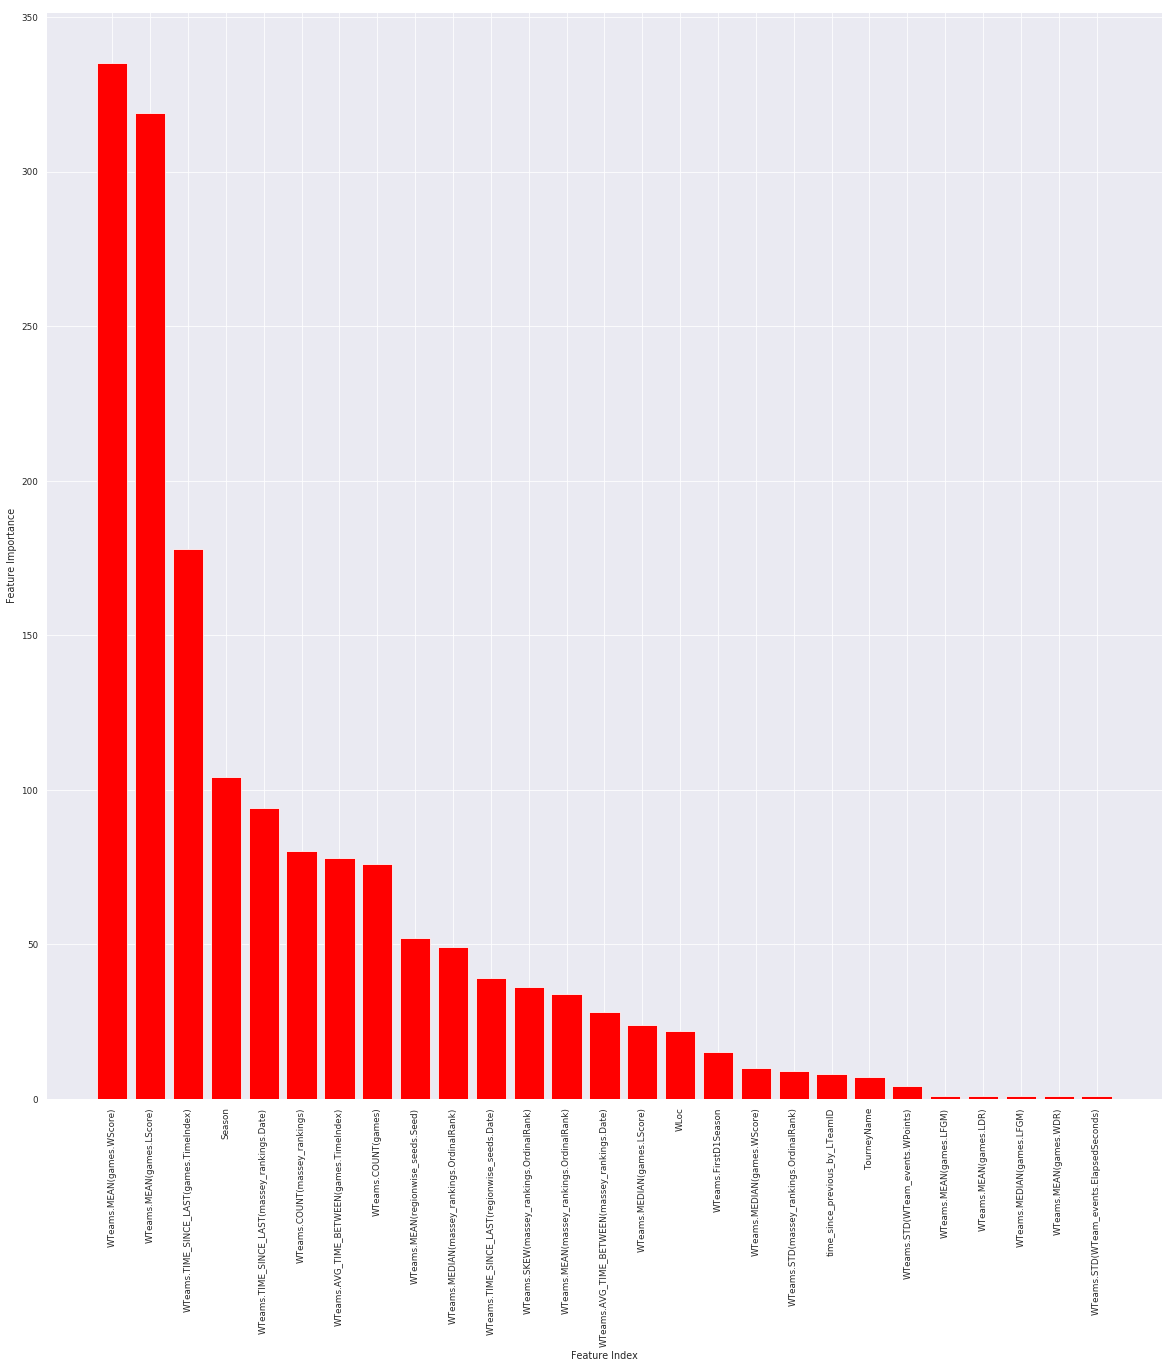

In [22]:
importances = clf_lgbm_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(20,20))
# names of important features based on plot above
important_features_idx = [idx for idx in sorted_idx if importances[idx] > 0.0]
important_features = {idx:X_train.columns[idx] for idx in important_features_idx}

# plot top 50 features
plt.bar(range(len(important_features_idx)), importances[list(important_features.keys())], color='r', align='center')
plt.xticks(range(len(important_features_idx)), list(important_features.values()), rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()

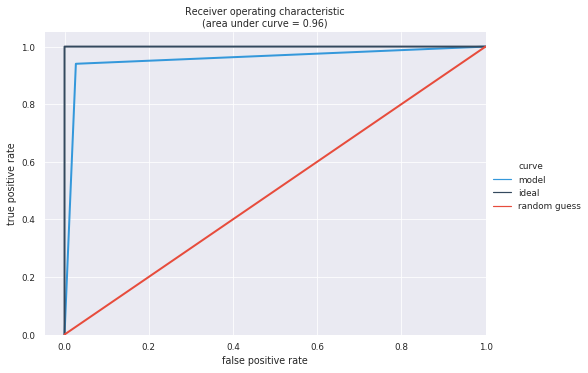

In [23]:
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test_1, y_pred_1_bins)
lgbm_roc_auc = auc(lgbm_fpr, lgbm_tpr)

plot_roc(lgbm_fpr, lgbm_tpr, lgbm_roc_auc)

### predicting for 2019

In [24]:
y_pred_2_lgbm = clf_lgbm_model.predict_proba(X_test_2)
y_pred_2_lgbm.shape

(2278, 2)

In [25]:
y_pred_2_lgbm[:,1]

array([0.81740708, 0.81740708, 0.81740708, ..., 0.24168474, 0.24168474,
       0.19674872])

In [55]:
ncaa_2019_games_lgbm = pd.read_csv(data_folder+'SampleSubmissionStage2.csv')
ncaa_2019_games_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 2 columns):
ID      2278 non-null object
Pred    2278 non-null float64
dtypes: float64(1), object(1)
memory usage: 35.7+ KB


In [56]:
ncaa_2019_games_lgbm['Pred'] = y_pred_2_lgbm[:,1]

In [57]:
ncaa_2019_games_lgbm.to_csv(data_folder+'SubmissionStage2_lgbm.csv')

In [31]:
! pip install binarytree
! pip install Pillow
! pip install bracketeer

    100% |████████████████████████████████| 2.0MB 3.8MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/7e/ed/d1bf72f166151627f00c9e60860363c5a13a8e406a22d5b6fb6099bb9eac/bracketeer-0.2.0.tar.gz
  Stored in directory: /home/siri/.cache/pip/wheels/22/fc/6e/c4fe2348b2f27862b3bc2184759a4d7c62b67f5817b5cfc4eb
Successfully built bracketeer


In [58]:
from bracketeer import build_bracket
b = build_bracket(
        outputPath='../img/bracket_pred_2019_lgbm.png',
        teamsPath=data_folder+'Teams.csv',
        seedsPath=data_folder+'NCAATourneySeeds.csv',
        submissionPath=data_folder+'SubmissionStage2_lgbm.csv',
        slotsPath=data_folder+'NCAATourneySlots.csv',
        #resultsPath=None,
        year=2019
)

<img src="../img/bracket_pred_2019_lgbm.png" width=905 height=996 align='left'></img>

### XGBoost (using important features selected by LightGBM)

In [43]:
list(important_features.values())

['WTeams.MEAN(games.WScore)',
 'WTeams.MEAN(games.LScore)',
 'WTeams.TIME_SINCE_LAST(games.TimeIndex)',
 'Season',
 'WTeams.TIME_SINCE_LAST(massey_rankings.Date)',
 'WTeams.COUNT(massey_rankings)',
 'WTeams.AVG_TIME_BETWEEN(games.TimeIndex)',
 'WTeams.COUNT(games)',
 'WTeams.MEAN(regionwise_seeds.Seed)',
 'WTeams.MEDIAN(massey_rankings.OrdinalRank)',
 'WTeams.TIME_SINCE_LAST(regionwise_seeds.Date)',
 'WTeams.SKEW(massey_rankings.OrdinalRank)',
 'WTeams.MEAN(massey_rankings.OrdinalRank)',
 'WTeams.AVG_TIME_BETWEEN(massey_rankings.Date)',
 'WTeams.MEDIAN(games.LScore)',
 'WLoc',
 'WTeams.FirstD1Season',
 'WTeams.MEDIAN(games.WScore)',
 'WTeams.STD(massey_rankings.OrdinalRank)',
 'time_since_previous_by_LTeamID',
 'TourneyName',
 'WTeams.STD(WTeam_events.WPoints)',
 'WTeams.MEAN(games.LFGM)',
 'WTeams.MEAN(games.LDR)',
 'WTeams.MEDIAN(games.LFGM)',
 'WTeams.MEAN(games.WDR)',
 'WTeams.STD(WTeam_events.ElapsedSeconds)']

In [48]:
X_train_imp = X_train[list(important_features.values())]
X_test_1_imp = X_test_1[list(important_features.values())]
X_test_2_imp = X_test_2[list(important_features.values())]

In [65]:
params_xgb = {'n_estimators' : [1,2,4,8,16,32,64,128,256],
          'gamma' : np.linspace(0.01,1,10),
          'learning_rate' : np.linspace(.01, 1, 10),
          'reg_lambda' : np.linspace(.01, 10, 10),
          'max_depth' : np.linspace(1, 32, 10, dtype=int)
        }
start = time.time()
cv_xgb  = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic',random_state=42), param_distributions=params_xgb, 
                             random_state=42, cv=5, n_jobs=4)
cv_xgb.fit(X_train, y_train)
end = time.time()
print(end - start)

dump(cv_xgb, data_folder+'xgb_ramdomcv.joblib')

1554.2405381202698


['/media/siri/78C6823EC681FD1E/minio/data/kaggle/ncaa/xgb_ramdomcv.joblib']

In [66]:
#cv_xgb = load(data_folder+'logr_ramdomcv.joblib')

clf_xgb_model = xgb.XGBClassifier(random_state=42,
                                  objective='binary:logistic',
                                  n_estimators=cv_xgb.best_params_['n_estimators'],
                                  gamma=cv_xgb.best_params_['gamma'],
                                  learning_rate=cv_xgb.best_params_['learning_rate'],
                                  reg_lambda=cv_xgb.best_params_['reg_lambda'],
                                  max_depth=cv_xgb.best_params_['max_depth'],
                                  n_jobs=3)
start = time.time()
clf_xgb_model.fit(X_train, y_train)
end = time.time()
print(end - start)

7.749459266662598


In [67]:
y_pred_1_xgb = clf_xgb_model.predict(X_test_1)
score_1_xgb = accuracy_score(y_test_1, y_pred_1_xgb)
rscore_1_xgb = recall_score(y_test_1, y_pred_1_xgb)
pscore_1_xgb = precision_score(y_test_1, y_pred_1_xgb)
print('Accuracy score for XGBoost ', score_1_xgb)
print('Recall score for XGBoost ', rscore_1_xgb)
print('Precision score for XGBoost ', pscore_1_xgb)
print(classification_report(y_test_1, y_pred_1_xgb, target_names=target_names))

Accuracy score for XGBoost  0.9597014925373134
Recall score for XGBoost  0.9194029850746268
Precision score for XGBoost  1.0
              precision    recall  f1-score   support

        wins       0.93      1.00      0.96       335
      losses       1.00      0.92      0.96       335

   micro avg       0.96      0.96      0.96       670
   macro avg       0.96      0.96      0.96       670
weighted avg       0.96      0.96      0.96       670



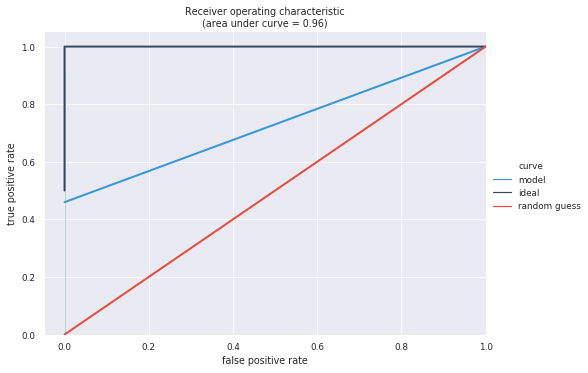

In [68]:
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_1, y_pred_1_xgb)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

plot_roc(xgb_fpr, xgb_tpr, xgb_roc_auc)

In [71]:
ncaa_2019_games_xgb = pd.read_csv(data_folder+'SampleSubmissionStage2.csv')
ncaa_2019_games_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 2 columns):
ID      2278 non-null object
Pred    2278 non-null float64
dtypes: float64(1), object(1)
memory usage: 35.7+ KB


In [73]:
y_pred_2_xgb = clf_xgb_model.predict_proba(X_test_2)

ncaa_2019_games_xgb['Pred'] = y_pred_2_xgb[:,1]

In [74]:
ncaa_2019_games_xgb.to_csv(data_folder+'SubmissionStage2_xgb.csv')

In [75]:
from bracketeer import build_bracket
b = build_bracket(
        outputPath='../img/bracket_pred_2019_xgb.png',
        teamsPath=data_folder+'Teams.csv',
        seedsPath=data_folder+'NCAATourneySeeds.csv',
        submissionPath=data_folder+'SubmissionStage2_xgb.csv',
        slotsPath=data_folder+'NCAATourneySlots.csv',
        #resultsPath=None,
        year=2019
)

<img src="../img/bracket_pred_2019_xgb.png" width=905 height=996 align='left'></img>

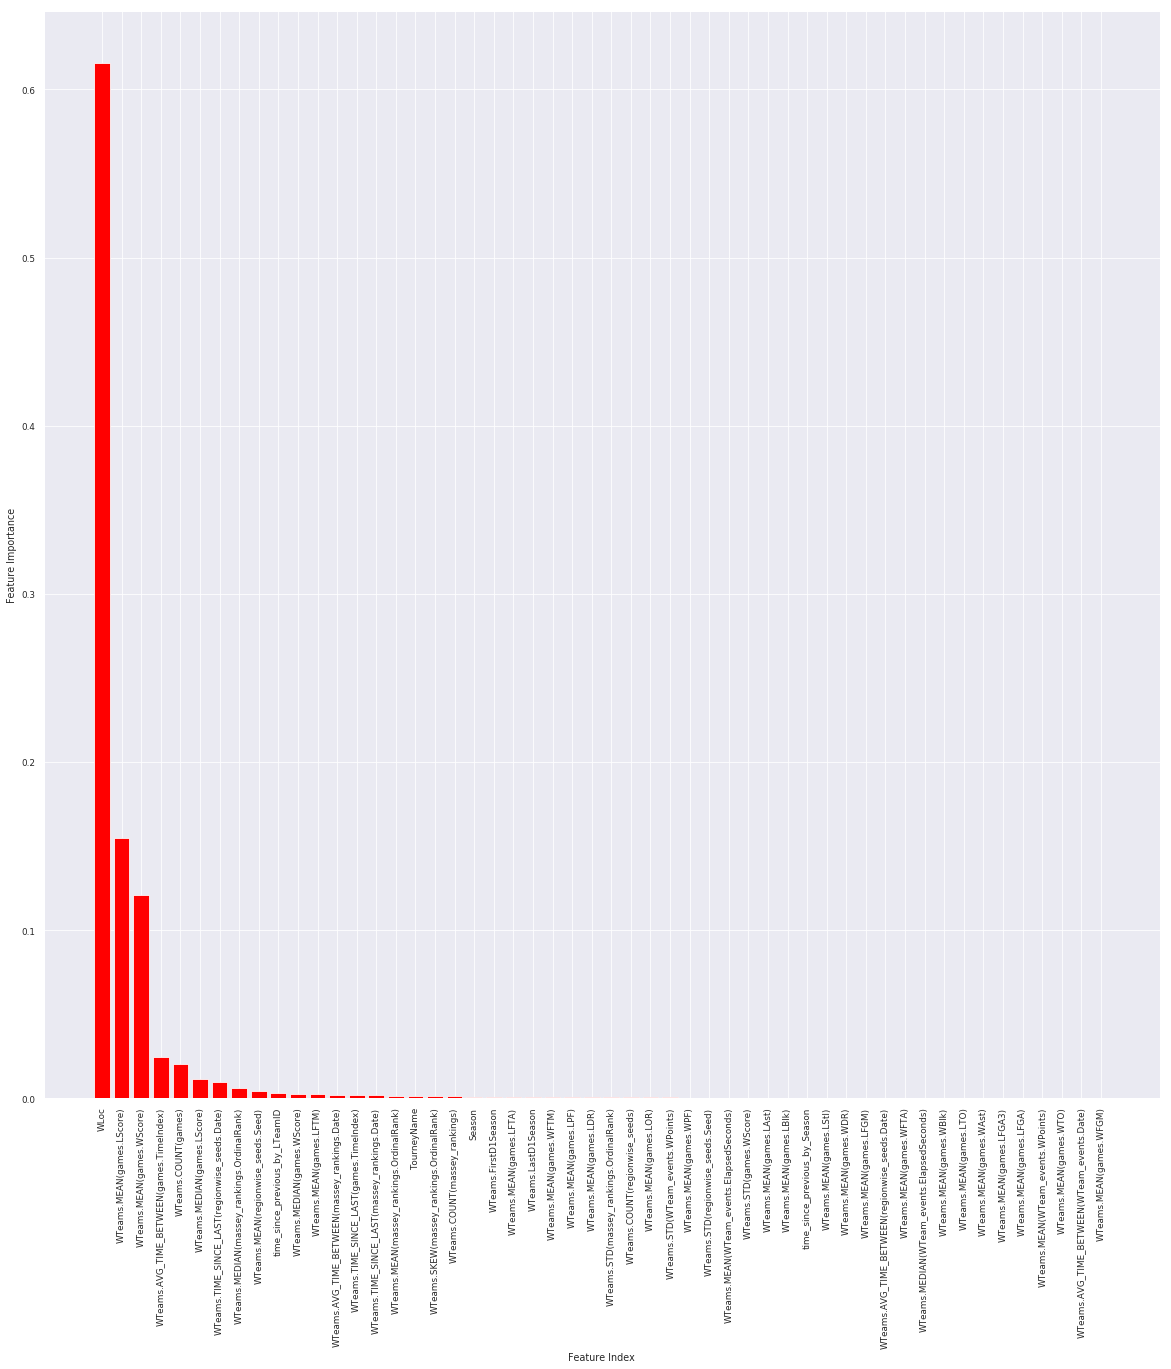

In [70]:
importances_xgb = clf_xgb_model.feature_importances_
sorted_idx_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(20,20))
# names of important features based on plot above
important_features_idx_xgb = [idx for idx in sorted_idx_xgb if importances_xgb[idx] > 0.0]
important_features_xgb = {idx:X_train.columns[idx] for idx in important_features_idx_xgb}

# plot top 50 features
plt.bar(range(len(important_features_idx_xgb)), importances_xgb[list(important_features_xgb.keys())], color='r', align='center')
plt.xticks(range(len(important_features_idx_xgb)), list(important_features_xgb.values()), rotation='vertical')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.show()